In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.append("../../")
from mat_interp.model.viz_model import plot_entropy_curve
%load_ext autoreload
%autoreload 2

# Visualization of raw experimental data and property calculation without interpolation

## **The problem**: Entropy calculation
To calculate the desired target quantity, a series of mathetical operations are required.
For example, here we are interested in the magnetic entropy change ($\Delta$S$_{M}$), given by:

$$
\begin{equation}
\Delta S_{M} (T, \mu_{0}\Delta H = H_{f} - H_{i}) = \mu_{0}\int_{H_{i}}^{H_{f}} \left(\frac{\partial M}{\partial T}\right)_{H} dH
\end{equation}
$$
Below, we show that using the raw experimental data measured leads to an 'spiky' oscilating behavior due to the lack of measurement in a more fine field step.


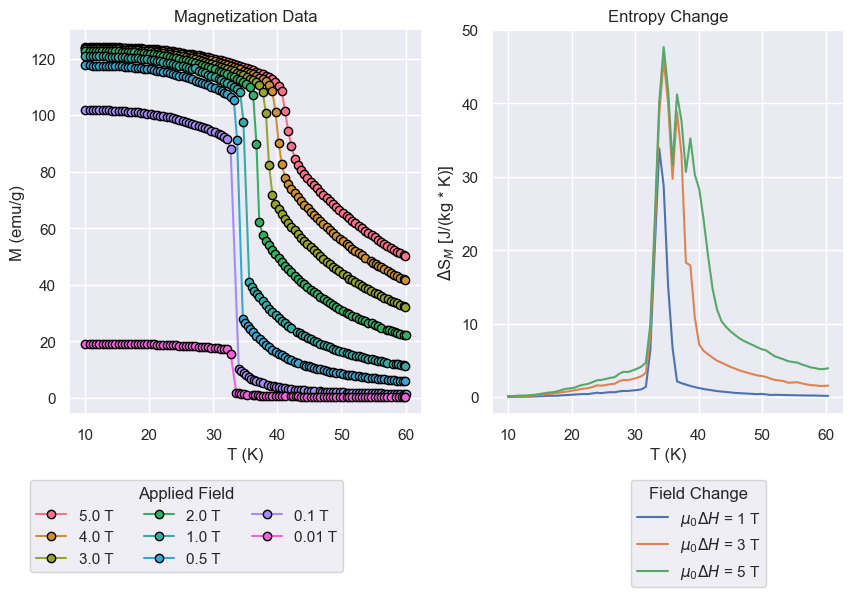

In [2]:
EXP_DATA = "../example_data/traindata_Section3_1.csv"
exp_df = pd.read_csv(EXP_DATA)

entropy_exp = plot_entropy_curve(data = exp_df, 
                                 temperature_column = "X1_demo1", 
                                 field_column="X2_demo1", 
                                 magnetization_column = "Y_demo1",
                                 return_entropy = True)

It is clear that with only those few fields measured (that is the often the common fields measured to calculate the entropy change assuming a material is of second-order), that those spiky values does not represent the true value. Specially, in the case of magnetocaloric materials, where the peak value of the entropy curve is used as base for comparison and calculation of different figure of merits (FOMs), this behavior can lead to a great overestimation of it.

Now here, we show that, by only using these few measured fields, it is possible to simulate at what step is necessary for us do redo our measurement in order to have a better accurate estimation of the entropy curve shape and values. Lets first, start by using a pre-trained model discussed in the paper, and later on lets move how to train and field the neural net that can do this.

# Simulating the data using the pre-trained model

Here we will show the simulation using two different models. For comparison with training data we show only the model discussed in the paper using the Streamlit interface. For comparison, we also show the model found by using the later section of this notebook (using jupyter interface).

In [5]:
SAVED_WEIGHTS = "weights"
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow_addons.metrics import RSquare
model = tf.keras.models.load_model(SAVED_WEIGHTS)

## Generating the same data as training data

In [83]:
# Get the features from the training experimental dataset and simulate magnetization
exp_df = pd.read_csv(EXP_DATA) # R
mean = exp_df['Y_demo1'].mean()
std = exp_df['Y_demo1'].std()
train_features = exp_df.loc[:, ['X1_demo1', 'X2_demo1']].to_numpy()
simulated_magnetization = model.predict(train_features)
simulated_df = pd.DataFrame(data = train_features, columns=['t', 'h'])
simulated_df['m_sim'] = simulated_magnetization
simulated_df['m_sim'] = (simulated_df['m_sim']) * std + mean # Unscale target

Text(0, 0.5, 'M (emu/g)')

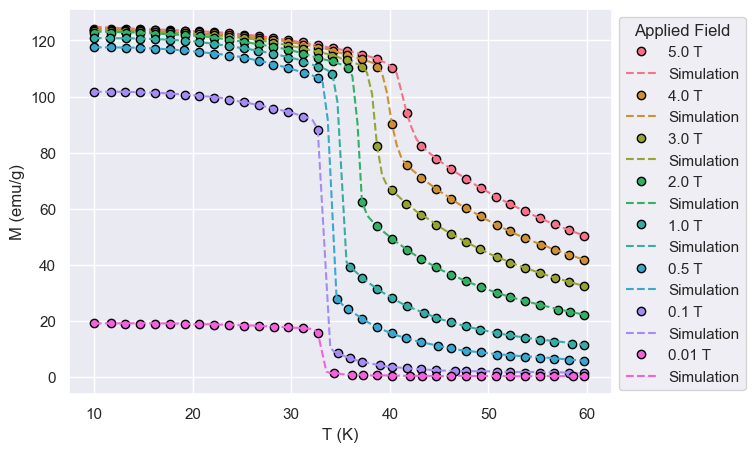

In [84]:
# Lets see the new data
WEIGHT = 0.61 * 1e-3
fig, ax = plt.subplots(figsize=(7,5))
colors = sns.color_palette(palette="husl", n_colors=len(measured_fields))
for field, clr in zip(measured_fields, colors):
    df_plot = exp_df.query('X2_demo1 == @field')
    df_plot_sim = simulated_df.query('h == @field')
    plt.plot(df_plot['X1_demo1'], df_plot['Y_demo1'] / WEIGHT, 'o',label=f"{field / 1e4} T", color=clr, mec='black', markevery=3)
    plt.plot(df_plot_sim.t, df_plot_sim['m_sim'] / WEIGHT, '--',color=clr, label="Simulation", lw=1.5)
    
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel("M (emu/g)")


## Generating data for new field steps

Ok now lets generate new field steps and see if we can get rid of the spikes. This will use the model mentioned in the paper

In [3]:
from mat_interp.model.viz_model import generate_data_mce

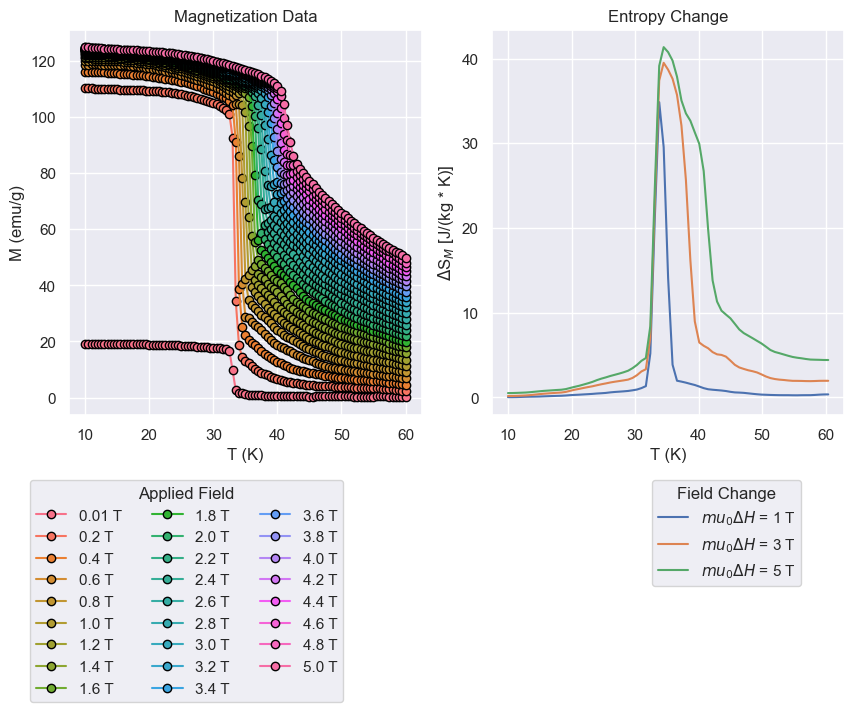

In [147]:
sim_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
sim_entropy = plot_entropy_curve(data=sim_data, 
                                 temperature_column="t", 
                                 field_column="h", 
                                 magnetization_column="m", 
                                 unstandarize=True,  
                                 bbox_mag = (0.8, -0.15), 
                                 n_cols=3, 
                                 bbox_ds = (0.9, -0.15),
                                 return_entropy = True)

Now lets use a model traiend using jupyter

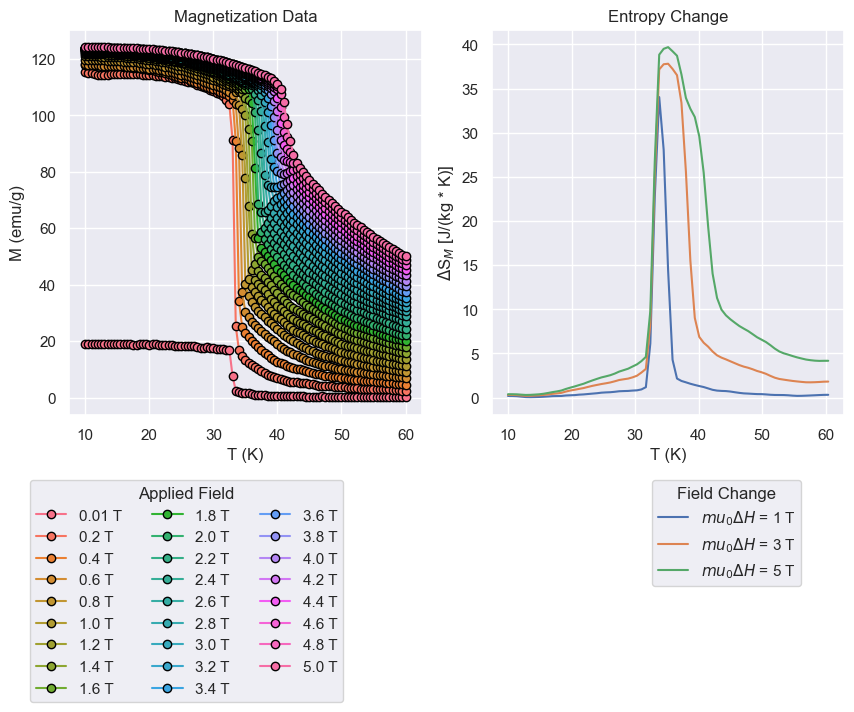

In [145]:
SAVED_WEIGHTS = "weights_jupyter"
model = tf.keras.models.load_model(SAVED_WEIGHTS)
sim_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
jupyter_sim = plot_entropy_curve(data=sim_data, temperature_column="t", field_column="h", magnetization_column="m", unstandarize=True,  bbox_mag = (0.8, -0.15), n_cols=3, bbox_ds = (0.9, -0.15), return_entropy = True)

## Finally lets visualize them together for 5 T

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

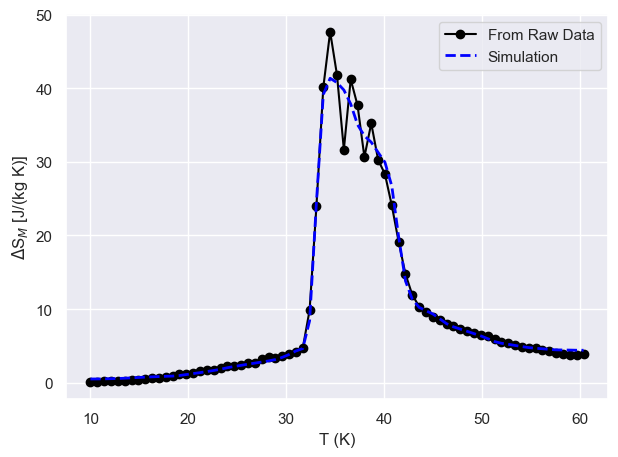

In [87]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'o-', mec='black', label = "From Raw Data", color='black')
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Checking up with the real (measured) data
We have just shown that if we simulate the data into 0.25 T steps, it would be enough to obtain a smooth non-spiky curve that does not overshoots the real value of the maxiumum entropy change. Lets compare, if we measured in this setup, how it would be in reality.

In [148]:
exp_data_fine = pd.read_csv("../example_data/experimental/fine_step.csv")

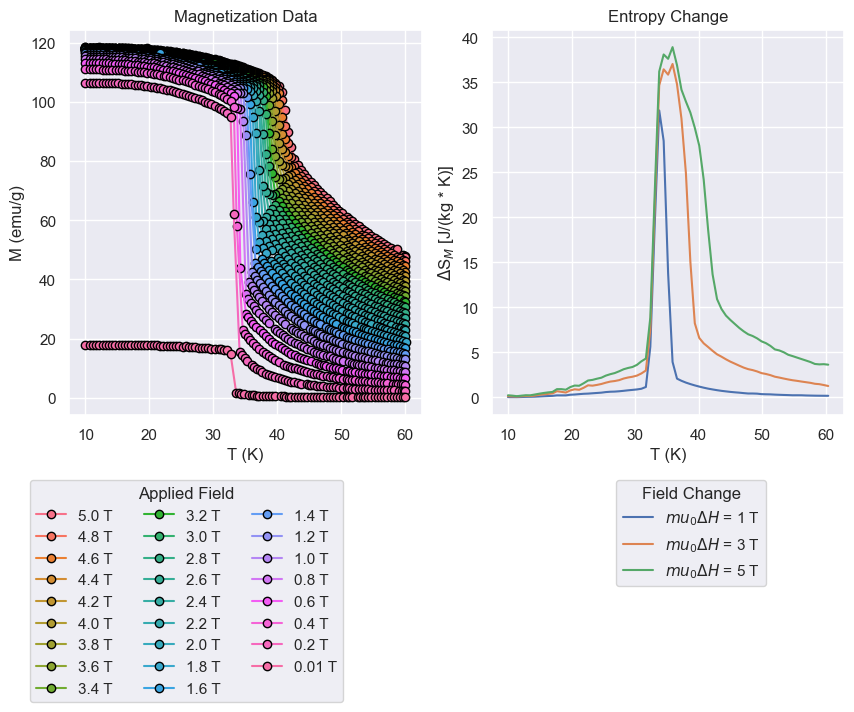

In [149]:
entropy_fine = plot_entropy_curve(exp_data_fine, temperature_column="t", magnetization_column="m", field_column="h", return_entropy=True)

## Lets compare now with the previously simulated data

> Note: The fine step data was taken from the same sample as the coarse one after a period of time has passed. The lower net magnetization observed is due to the the degradation of the sample with time (this experiments was done in a large time period over many months)

## Calculating the simulated entropy

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

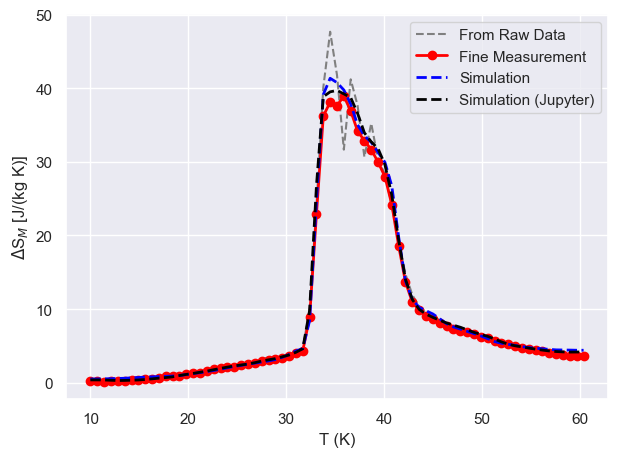

In [150]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    df_plot_3 = entropy_fine.query("dh == @field")
    df_plot_4 = jupyter_sim.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From Raw Data", color='grey')
    plt.plot(df_plot_3.t, df_plot_3.ds,'o-', label = "Fine Measurement", color='red', lw=2)
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
    plt.plot(df_plot_4.t, df_plot_4.ds,'--', label = "Simulation (Jupyter)", color='black', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Finding a new model

In [8]:
from mat_interp.model.train_model import load_train_data, optimize_neural_net

# Setup the data (same as before) and the target columsn
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)

In [22]:
# Search settings
nn_settings = {
    "epochs": 500,
    "solver": "Adam",
    "X_train": X_train,
    "y_train": y_train,
    "num_trials": 100,
    "working_dir": "nn_search",
}

# Run search
optimize_neural_net(**nn_settings)

[I 2022-12-20 10:13:08,340] A new study created in memory with name: optuna_NNtemp
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


Starting optimization process...
Creating nn with layers: 5 and nodes: 170 starting with learning rate 0.0007385365658158151 for trial 0.... regularizaiton value is set to 0.0...
Creating nn with layers: 8 and nodes: 99 starting with learning rate 0.0022530056287861523 for trial 1.... regularizaiton value is set to 0.0...
Creating nn with layers: 9 and nodes: 75 starting with learning rate 0.003031510727846356 for trial 2.... regularizaiton value is set to 0.0...
Creating nn with layers: 5 and nodes: 56 starting with learning rate 0.0018804407774283658 for trial 3.... regularizaiton value is set to 0.0...
Creating nn with layers: 3 and nodes: 161 starting with learning rate 0.0012642927718718418 for trial 4.... regularizaiton value is set to 0.0...
Creating nn with layers: 10 and nodes: 128 starting with learning rate 0.0012503109805591223 for trial 5.... regularizaiton value is set to 0.0...
Creating nn with layers: 6 and nodes: 190 starting with learning rate 0.002304462523892228 for

[I 2022-12-20 10:13:35,240] Trial 10 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 9 and nodes: 172 starting with learning rate 0.0010157412657914983 for trial 12.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:13:36,682] Trial 0 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 8 and nodes: 64 starting with learning rate 0.0006875814743224307 for trial 13.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:13:38,067] Trial 7 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 5 and nodes: 156 starting with learning rate 0.0011692982839468697 for trial 14.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:13:54,088] Trial 14 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 10 and nodes: 51 starting with learning rate 0.0014722268279064486 for trial 15.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:14:07,119] Trial 13 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 5 and nodes: 58 starting with learning rate 0.004192493739904931 for trial 16.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_11/assets


[I 2022-12-20 10:14:14,558] Trial 11 finished with value: 0.9999727010726929 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 147, 'starting_lr': 0.0035454415401317474, 'batchsize': 64}. Best is trial 11 with value: 0.9999727010726929.


Creating nn with layers: 6 and nodes: 188 starting with learning rate 0.0005054737084670818 for trial 17.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:14:15,591] Trial 12 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 8 and nodes: 63 starting with learning rate 0.001886499405066277 for trial 18.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_3/assets


[I 2022-12-20 10:14:33,986] Trial 3 finished with value: 0.999942421913147 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 56, 'starting_lr': 0.0018804407774283658, 'batchsize': 128}. Best is trial 11 with value: 0.9999727010726929.


Creating nn with layers: 8 and nodes: 78 starting with learning rate 0.0012520540185496677 for trial 19.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:14:37,065] Trial 17 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 94 starting with learning rate 0.0012437361372502804 for trial 20.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:14:42,288] Trial 8 pruned. Trial was pruned at epoch 200.


Creating nn with layers: 10 and nodes: 126 starting with learning rate 0.0041465002429014524 for trial 21.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_2/assets


[I 2022-12-20 10:14:45,821] Trial 2 finished with value: 0.9999442100524902 and parameters: {'num_layers': 9, 'num_nodes_per_layer': 75, 'starting_lr': 0.003031510727846356, 'batchsize': 128}. Best is trial 11 with value: 0.9999727010726929.


Creating nn with layers: 10 and nodes: 125 starting with learning rate 0.003732656421298199 for trial 22.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_4/assets


[I 2022-12-20 10:14:50,393] Trial 4 finished with value: 0.9986009001731873 and parameters: {'num_layers': 3, 'num_nodes_per_layer': 161, 'starting_lr': 0.0012642927718718418, 'batchsize': 256}. Best is trial 11 with value: 0.9999727010726929.


Creating nn with layers: 10 and nodes: 115 starting with learning rate 0.003849937357818989 for trial 23.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_9/assets


[I 2022-12-20 10:14:53,977] Trial 9 finished with value: 0.9999836683273315 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 111, 'starting_lr': 0.003943640782761347, 'batchsize': 128}. Best is trial 9 with value: 0.9999836683273315.


Creating nn with layers: 10 and nodes: 122 starting with learning rate 0.004861252086239399 for trial 24.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:14:56,975] Trial 5 pruned. Trial was pruned at epoch 200.


Creating nn with layers: 10 and nodes: 119 starting with learning rate 0.004987460728480764 for trial 25.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_6/assets


[I 2022-12-20 10:15:02,097] Trial 6 finished with value: 0.9999936819076538 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 190, 'starting_lr': 0.002304462523892228, 'batchsize': 256}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 109 starting with learning rate 0.004904915113870841 for trial 26.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:15:05,457] Trial 20 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 7 and nodes: 113 starting with learning rate 0.0045846002509584045 for trial 27.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_16/assets


[I 2022-12-20 10:15:09,200] Trial 16 finished with value: 0.9999886751174927 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 58, 'starting_lr': 0.004192493739904931, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 197 starting with learning rate 0.002582586101921931 for trial 28.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_1/assets


[I 2022-12-20 10:15:14,567] Trial 1 finished with value: 0.9999897480010986 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 99, 'starting_lr': 0.0022530056287861523, 'batchsize': 128}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 125 starting with learning rate 0.0022902409845829887 for trial 29.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_25/assets


[I 2022-12-20 10:15:22,714] Trial 25 finished with value: 0.9876595735549927 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 119, 'starting_lr': 0.004987460728480764, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 198 starting with learning rate 0.0022705330876853064 for trial 30.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:15:29,159] Trial 19 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 7 and nodes: 135 starting with learning rate 0.002117548518744053 for trial 31.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_24/assets


[I 2022-12-20 10:15:34,286] Trial 24 finished with value: 0.9995613694190979 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 122, 'starting_lr': 0.004861252086239399, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 103 starting with learning rate 0.0021849990869997156 for trial 32.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:15:48,617] Trial 31 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 6 and nodes: 104 starting with learning rate 0.0022465660092270126 for trial 33.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_18/assets


[I 2022-12-20 10:15:51,071] Trial 18 finished with value: 0.9999868869781494 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 63, 'starting_lr': 0.001886499405066277, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 6 and nodes: 103 starting with learning rate 0.002573494253818026 for trial 34.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:15:52,439] Trial 15 pruned. Trial was pruned at epoch 200.


Creating nn with layers: 6 and nodes: 101 starting with learning rate 0.0025988255728566275 for trial 35.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:15:54,709] Trial 27 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 6 and nodes: 100 starting with learning rate 0.0026802161817033655 for trial 36.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_26/assets


[I 2022-12-20 10:16:15,798] Trial 26 finished with value: 0.9999923706054688 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 109, 'starting_lr': 0.004904915113870841, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 6 and nodes: 105 starting with learning rate 0.0026971573693071647 for trial 37.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:16:18,030] Trial 36 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 7 and nodes: 103 starting with learning rate 0.0024352433468717762 for trial 38.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_21/assets


[I 2022-12-20 10:16:24,053] Trial 21 finished with value: 0.9999822378158569 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 126, 'starting_lr': 0.0041465002429014524, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 103 starting with learning rate 0.00248340918310687 for trial 39.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_23/assets


[I 2022-12-20 10:16:31,568] Trial 23 finished with value: 0.9999818801879883 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 115, 'starting_lr': 0.003849937357818989, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 194 starting with learning rate 0.002614876805761207 for trial 40.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_37/assets


[I 2022-12-20 10:16:35,040] Trial 37 finished with value: 0.9364585280418396 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 105, 'starting_lr': 0.0026971573693071647, 'batchsize': 256}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 199 starting with learning rate 0.0023014876500476317 for trial 41.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_29/assets


[I 2022-12-20 10:16:39,256] Trial 29 finished with value: 0.9999926686286926 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 125, 'starting_lr': 0.0022902409845829887, 'batchsize': 64}. Best is trial 6 with value: 0.9999936819076538.


Creating nn with layers: 7 and nodes: 139 starting with learning rate 0.002038779864105566 for trial 42.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_28/assets


[I 2022-12-20 10:16:41,516] Trial 28 finished with value: 0.9999961853027344 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 197, 'starting_lr': 0.002582586101921931, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 7 and nodes: 198 starting with learning rate 0.0031125034978179795 for trial 43.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_32/assets


[I 2022-12-20 10:16:46,715] Trial 32 finished with value: 0.9999809265136719 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 103, 'starting_lr': 0.0021849990869997156, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 7 and nodes: 197 starting with learning rate 0.003189269925721785 for trial 44.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_22/assets


[I 2022-12-20 10:16:54,610] Trial 22 finished with value: 0.9999911785125732 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 125, 'starting_lr': 0.003732656421298199, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 7 and nodes: 193 starting with learning rate 0.003051934426776948 for trial 45.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:16:59,385] Trial 39 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 6 and nodes: 197 starting with learning rate 0.003281778602756867 for trial 46.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:17:04,871] Trial 42 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 6 and nodes: 199 starting with learning rate 0.001655931188930815 for trial 47.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_33/assets


[I 2022-12-20 10:17:05,015] Trial 33 finished with value: 0.9999818801879883 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 104, 'starting_lr': 0.0022465660092270126, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 6 and nodes: 197 starting with learning rate 0.0031383616772416765 for trial 48.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_34/assets


[I 2022-12-20 10:17:08,132] Trial 34 finished with value: 0.9999908804893494 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 103, 'starting_lr': 0.002573494253818026, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 9 and nodes: 200 starting with learning rate 0.0031321601204004276 for trial 49.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:17:12,559] Trial 41 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 179 starting with learning rate 0.0030088361746680066 for trial 50.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:17:24,906] Trial 47 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 9 and nodes: 177 starting with learning rate 0.0030614813834470163 for trial 51.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_35/assets


[I 2022-12-20 10:17:26,793] Trial 35 finished with value: 0.9999914765357971 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 101, 'starting_lr': 0.0025988255728566275, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 9 and nodes: 180 starting with learning rate 0.0030280121738919122 for trial 52.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:17:38,936] Trial 40 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 9 and nodes: 178 starting with learning rate 0.003143941707062233 for trial 53.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_43/assets


[I 2022-12-20 10:17:41,382] Trial 43 finished with value: 0.999982476234436 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 198, 'starting_lr': 0.0031125034978179795, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 182 starting with learning rate 0.003165043148043837 for trial 54.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_30/assets


[I 2022-12-20 10:17:46,312] Trial 30 finished with value: 0.9999930262565613 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 198, 'starting_lr': 0.0022705330876853064, 'batchsize': 256}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 9 and nodes: 180 starting with learning rate 0.0032687723754060132 for trial 55.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_44/assets


[I 2022-12-20 10:18:00,000] Trial 44 finished with value: 0.9999945163726807 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 197, 'starting_lr': 0.003189269925721785, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 9 and nodes: 180 starting with learning rate 0.003220966009827527 for trial 56.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_38/assets


[I 2022-12-20 10:18:00,960] Trial 38 finished with value: 0.999992847442627 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 103, 'starting_lr': 0.0024352433468717762, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 8 and nodes: 185 starting with learning rate 0.0031231128827406843 for trial 57.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_48/assets


[I 2022-12-20 10:18:07,830] Trial 48 finished with value: 0.9999850988388062 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 197, 'starting_lr': 0.0031383616772416765, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 9 and nodes: 179 starting with learning rate 0.00335929024455178 for trial 58.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_46/assets


[I 2022-12-20 10:18:19,210] Trial 46 finished with value: 0.9999930262565613 and parameters: {'num_layers': 6, 'num_nodes_per_layer': 197, 'starting_lr': 0.003281778602756867, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 9 and nodes: 180 starting with learning rate 0.0033224402062479678 for trial 59.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:20,895] Trial 55 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 5 and nodes: 184 starting with learning rate 0.00292247017888676 for trial 60.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_50/assets


[I 2022-12-20 10:18:24,792] Trial 50 finished with value: 0.9999949336051941 and parameters: {'num_layers': 4, 'num_nodes_per_layer': 179, 'starting_lr': 0.0030088361746680066, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 4 and nodes: 185 starting with learning rate 0.003435652907263324 for trial 61.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:27,035] Trial 56 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 188 starting with learning rate 0.00283224999584602 for trial 62.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:32,475] Trial 57 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 169 starting with learning rate 0.002869582915378652 for trial 63.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_45/assets


[I 2022-12-20 10:18:35,633] Trial 45 finished with value: 0.9999934434890747 and parameters: {'num_layers': 7, 'num_nodes_per_layer': 193, 'starting_lr': 0.003051934426776948, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 4 and nodes: 171 starting with learning rate 0.0017219432360777646 for trial 64.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:40,641] Trial 58 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 167 starting with learning rate 0.0028784956056093396 for trial 65.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:41,524] Trial 51 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 5 and nodes: 165 starting with learning rate 0.002841251182319456 for trial 66.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_54/assets


[I 2022-12-20 10:18:43,476] Trial 54 finished with value: 0.9999952912330627 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 182, 'starting_lr': 0.003165043148043837, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 4 and nodes: 164 starting with learning rate 0.002831609728058988 for trial 67.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:46,168] Trial 60 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 164 starting with learning rate 0.0028480032662020122 for trial 68.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:48,656] Trial 62 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 164 starting with learning rate 0.003536673053064897 for trial 69.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:52,489] Trial 63 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 164 starting with learning rate 0.003573945530073778 for trial 70.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:54,949] Trial 59 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 4 and nodes: 161 starting with learning rate 0.003580288631294492 for trial 71.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:18:57,524] Trial 64 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 5 and nodes: 160 starting with learning rate 0.003540986632884876 for trial 72.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:00,987] Trial 65 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 3 and nodes: 190 starting with learning rate 0.0035809688595951606 for trial 73.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_53/assets


[I 2022-12-20 10:19:05,339] Trial 53 finished with value: 0.9999839067459106 and parameters: {'num_layers': 9, 'num_nodes_per_layer': 178, 'starting_lr': 0.003143941707062233, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 191 starting with learning rate 0.0035567706236063795 for trial 74.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:06,653] Trial 68 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 3 and nodes: 191 starting with learning rate 0.0036590774375512124 for trial 75.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:07,626] Trial 49 pruned. Trial was pruned at epoch 200.


Creating nn with layers: 5 and nodes: 192 starting with learning rate 0.0035593566794352945 for trial 76.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_52/assets


[I 2022-12-20 10:19:16,100] Trial 52 finished with value: 0.9999951720237732 and parameters: {'num_layers': 9, 'num_nodes_per_layer': 180, 'starting_lr': 0.0030280121738919122, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 3 and nodes: 191 starting with learning rate 0.003688647308910886 for trial 77.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:21,798] Trial 71 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 5 and nodes: 155 starting with learning rate 0.004149916336633359 for trial 78.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:23,968] Trial 73 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 5 and nodes: 154 starting with learning rate 0.00415200478732036 for trial 79.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_61/assets


[I 2022-12-20 10:19:29,694] Trial 61 finished with value: 0.9999942183494568 and parameters: {'num_layers': 4, 'num_nodes_per_layer': 185, 'starting_lr': 0.003435652907263324, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 148 starting with learning rate 0.004214562819598244 for trial 80.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:30,820] Trial 66 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 5 and nodes: 174 starting with learning rate 0.004090964369499885 for trial 81.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:33,614] Trial 77 pruned. Trial was pruned at epoch 50.


Creating nn with layers: 8 and nodes: 192 starting with learning rate 0.004172568993923125 for trial 82.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:35,529] Trial 69 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 5 and nodes: 174 starting with learning rate 0.004017167119742198 for trial 83.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:36,617] Trial 70 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 5 and nodes: 154 starting with learning rate 0.0041776537003748995 for trial 84.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:43,807] Trial 72 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 8 and nodes: 185 starting with learning rate 0.0042944952040818865 for trial 85.... regularizaiton value is set to 0.0...


[I 2022-12-20 10:19:44,776] Trial 75 pruned. Trial was pruned at epoch 100.


Creating nn with layers: 8 and nodes: 153 starting with learning rate 0.0045032145705652185 for trial 86.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_67/assets


[I 2022-12-20 10:19:55,961] Trial 67 finished with value: 0.9999902248382568 and parameters: {'num_layers': 4, 'num_nodes_per_layer': 164, 'starting_lr': 0.002831609728058988, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 8 and nodes: 175 starting with learning rate 0.004049079915997657 for trial 87.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_74/assets


[I 2022-12-20 10:20:09,910] Trial 74 finished with value: 0.9999945759773254 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 191, 'starting_lr': 0.0035567706236063795, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 174 starting with learning rate 0.004175560307782351 for trial 88.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_76/assets


[I 2022-12-20 10:20:14,889] Trial 76 finished with value: 0.9999936819076538 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 192, 'starting_lr': 0.0035593566794352945, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 174 starting with learning rate 0.004188800489928353 for trial 89.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_78/assets


[I 2022-12-20 10:20:20,999] Trial 78 finished with value: 0.9999922513961792 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 155, 'starting_lr': 0.004149916336633359, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 174 starting with learning rate 0.004012039098140277 for trial 90.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_79/assets


[I 2022-12-20 10:20:23,636] Trial 79 finished with value: 0.9999943971633911 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 154, 'starting_lr': 0.00415200478732036, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 184 starting with learning rate 0.004383281659034635 for trial 91.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_84/assets


[I 2022-12-20 10:20:31,247] Trial 84 finished with value: 0.9999914765357971 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 154, 'starting_lr': 0.0041776537003748995, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 185 starting with learning rate 0.004580754944884995 for trial 92.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_81/assets


[I 2022-12-20 10:20:33,467] Trial 81 finished with value: 0.9999904036521912 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 174, 'starting_lr': 0.004090964369499885, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 8 and nodes: 185 starting with learning rate 0.004498092407267778 for trial 93.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_80/assets


[I 2022-12-20 10:20:36,909] Trial 80 finished with value: 0.999988317489624 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 148, 'starting_lr': 0.004214562819598244, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 184 starting with learning rate 0.0044777331572133355 for trial 94.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_86/assets


[I 2022-12-20 10:20:50,527] Trial 86 finished with value: 0.9999672174453735 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 153, 'starting_lr': 0.0045032145705652185, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 8 and nodes: 182 starting with learning rate 0.0038595939687035693 for trial 95.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_83/assets


[I 2022-12-20 10:21:00,378] Trial 83 finished with value: 0.9999906420707703 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 174, 'starting_lr': 0.004017167119742198, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 185 starting with learning rate 0.004651263421365276 for trial 96.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_82/assets


[I 2022-12-20 10:21:07,135] Trial 82 finished with value: 0.9999908208847046 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 192, 'starting_lr': 0.004172568993923125, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 5 and nodes: 185 starting with learning rate 0.001438982608269665 for trial 97.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_87/assets


[I 2022-12-20 10:21:14,877] Trial 87 finished with value: 0.9999896287918091 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 175, 'starting_lr': 0.004049079915997657, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 6 and nodes: 184 starting with learning rate 0.0007923781957100216 for trial 98.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_89/assets


[I 2022-12-20 10:21:22,204] Trial 89 finished with value: 0.9999927878379822 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 174, 'starting_lr': 0.004188800489928353, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Creating nn with layers: 6 and nodes: 185 starting with learning rate 0.0008094796498370692 for trial 99.... regularizaiton value is set to 0.0...
INFO:tensorflow:Assets written to: nn_search/modeltrial_88/assets


[I 2022-12-20 10:21:23,718] Trial 88 finished with value: 0.9999872446060181 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 174, 'starting_lr': 0.004175560307782351, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


INFO:tensorflow:Assets written to: nn_search/modeltrial_85/assets


[I 2022-12-20 10:21:29,256] Trial 85 finished with value: 0.9999935030937195 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 185, 'starting_lr': 0.0042944952040818865, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.
[I 2022-12-20 10:21:30,316] Trial 97 pruned. Trial was pruned at epoch 50.
[I 2022-12-20 10:21:31,743] Trial 94 pruned. Trial was pruned at epoch 100.


INFO:tensorflow:Assets written to: nn_search/modeltrial_90/assets


[I 2022-12-20 10:21:34,788] Trial 90 finished with value: 0.9999929070472717 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 174, 'starting_lr': 0.004012039098140277, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.
[I 2022-12-20 10:21:37,636] Trial 98 pruned. Trial was pruned at epoch 50.


INFO:tensorflow:Assets written to: nn_search/modeltrial_92/assets


[I 2022-12-20 10:21:39,330] Trial 92 finished with value: 0.9999797940254211 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 185, 'starting_lr': 0.004580754944884995, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.
[I 2022-12-20 10:21:39,942] Trial 99 pruned. Trial was pruned at epoch 50.


INFO:tensorflow:Assets written to: nn_search/modeltrial_91/assets


[I 2022-12-20 10:21:43,449] Trial 91 finished with value: 0.9999857544898987 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 184, 'starting_lr': 0.004383281659034635, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


INFO:tensorflow:Assets written to: nn_search/modeltrial_96/assets


[I 2022-12-20 10:21:52,647] Trial 96 finished with value: 0.999994158744812 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 185, 'starting_lr': 0.004651263421365276, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


INFO:tensorflow:Assets written to: nn_search/modeltrial_93/assets


[I 2022-12-20 10:21:54,081] Trial 93 finished with value: 0.9999889731407166 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 185, 'starting_lr': 0.004498092407267778, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


INFO:tensorflow:Assets written to: nn_search/modeltrial_95/assets


[I 2022-12-20 10:21:54,216] Trial 95 finished with value: 0.9999918341636658 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 182, 'starting_lr': 0.0038595939687035693, 'batchsize': 64}. Best is trial 28 with value: 0.9999961853027344.


Optimization Finished.
Fineshed cleaning up files.. best model kept at nn_search/modeltrial_28


# Now we can see the best model


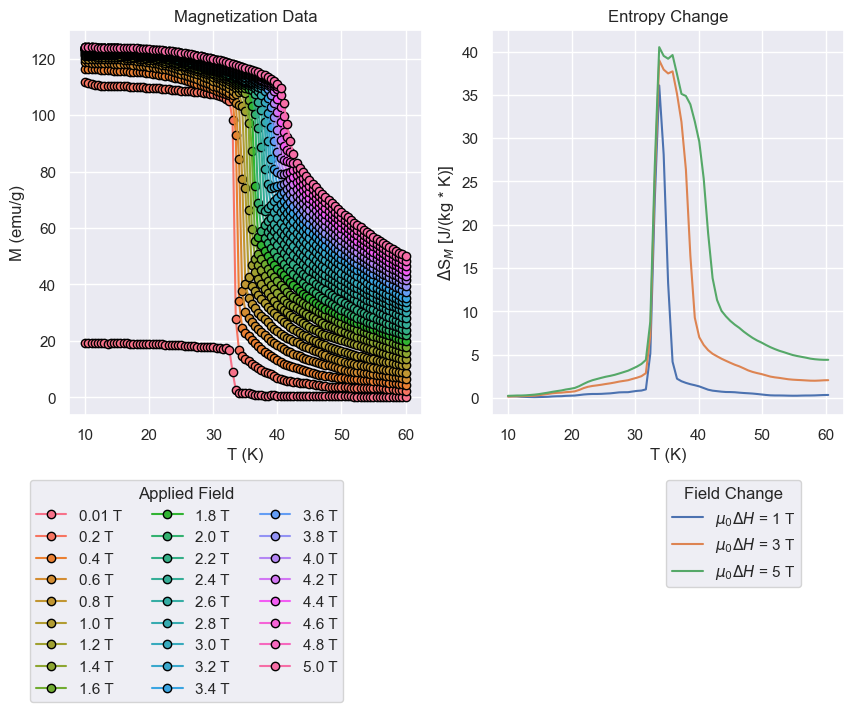

In [23]:
SAVED_WEIGHTS = "nn_search/modeltrial_28"
model = tf.keras.models.load_model(SAVED_WEIGHTS)
sim_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
new_model_entropy = plot_entropy_curve(data=sim_data, 
                                       temperature_column="t", 
                                       field_column="h", 
                                       magnetization_column="m", 
                                       unstandarize=True,  
                                       bbox_mag = (0.8, -0.15), 
                                       n_cols=3, 
                                       bbox_ds = (0.9, -0.15), 
                                       return_entropy = True)

In [13]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 2)                 5         
_________________________________________________________________
layer0 (Dense)               (None, 171)               513       
_________________________________________________________________
layer1 (Dense)               (None, 171)               29412     
_________________________________________________________________
layer2 (Dense)               (None, 171)               29412     
_________________________________________________________________
layer3 (Dense)               (None, 171)               29412     
_________________________________________________________________
layer4 (Dense)               (None, 171)               29412     
_________________________________________________________________
layer5 (Dense)               (None, 171)              

## Finally comparing with all the other models:


NameError: name 'sim_entropy' is not defined

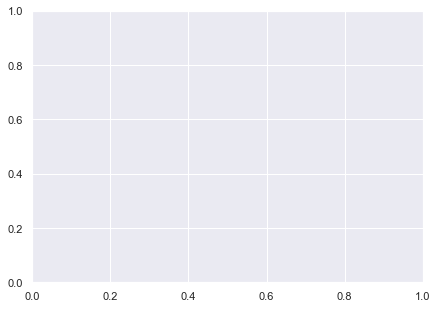

In [22]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    df_plot_3 = entropy_fine.query("dh == @field")
    df_plot_4 = jupyter_sim.query("dh == @field")
    df_plot_5 = new_model_entropy.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From Raw Data", color='grey')
    plt.plot(df_plot_3.t, df_plot_3.ds,'o-', label = "Fine Measurement", color='red', lw=2)
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation (Streamlit)", color='blue', lw=2)
    plt.plot(df_plot_4.t, df_plot_4.ds,'--', label = "Simulation (Jupyter)", color='black', lw=2)
    plt.plot(df_plot_5.t, df_plot_5.ds,'--', label = "Simulation (This model)", color='purple', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Comparison with Scikit learn modules

Here we will show the usage of scikit-learn modules such as RandomForest Regression, Linear Regression and MLP Regressor

In [225]:
from mat_interp.model.train_model import load_train_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mat_interp.model.viz_model import generate_data_mce

# Setup the data (same as before) and the target columsn
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [226]:
scaler = StandardScaler()
pipe_model = lambda pipe_model: Pipeline([['scaler', scaler], ['model', pipe_model]])

In [227]:
linear = pipe_model(LinearRegression())
rf = pipe_model(RandomForestRegressor(n_jobs = - 1))
nn_skl = pipe_model(MLPRegressor(hidden_layer_sizes=(193,) *6, 
             learning_rate_init=0.00434, 
             max_iter = 500, 
             early_stopping=True, 
             ))
guassian_process = pipe_model(GaussianProcessRegressor())
kernel_ridge = pipe_model(KernelRidge(kernel = "rbf"))

In [228]:
models = [("linear", linear), 
          ("random forest", rf), 
          ("nn-scikit", nn_skl), 
          ("gaussian_process", guassian_process), 
          ("kernel", kernel_ridge)]
results = {}

Training linear....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training random forest....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training nn-scikit....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training gaussian_process....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training kernel....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!


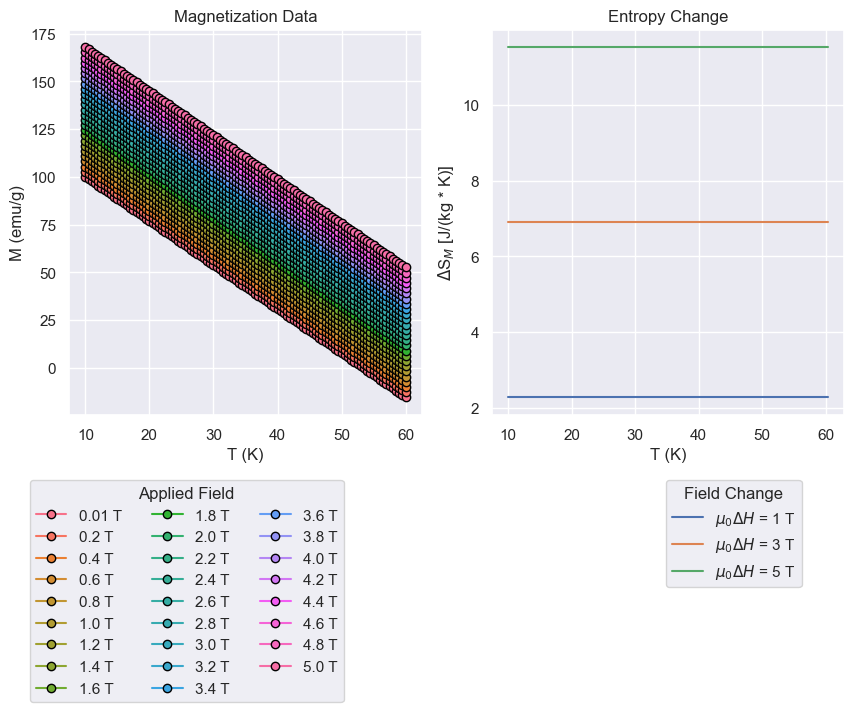

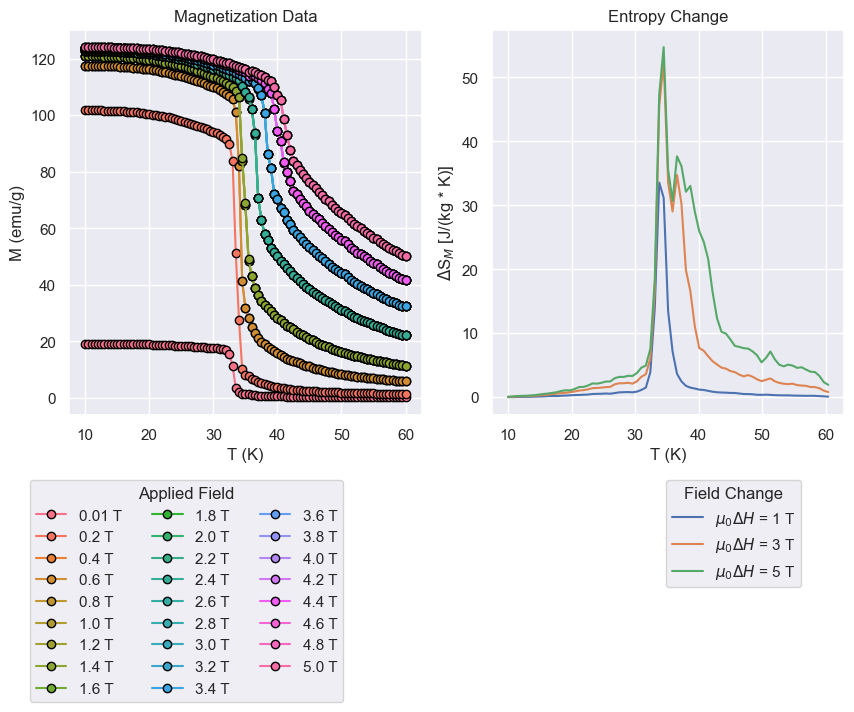

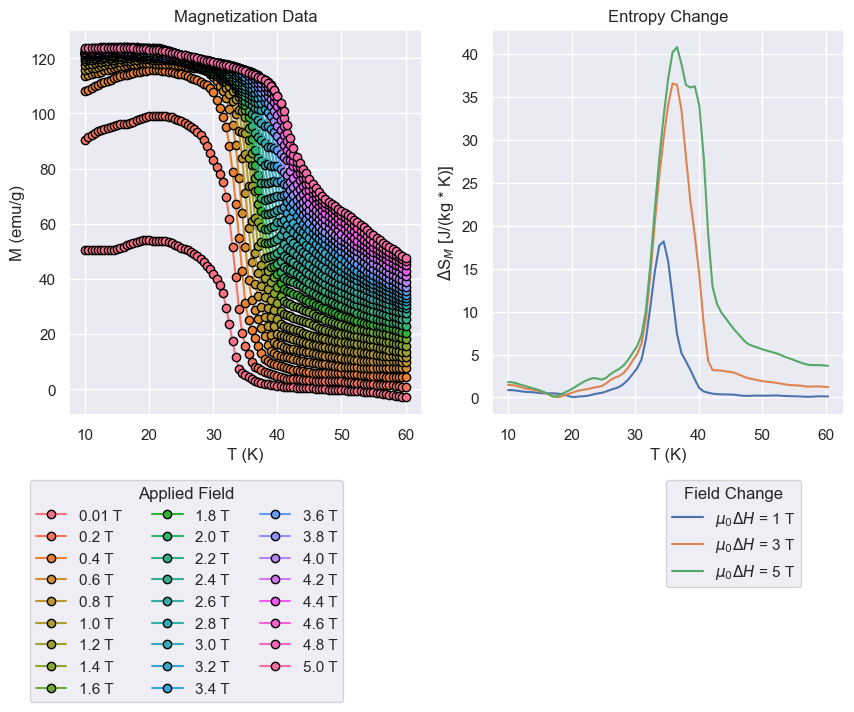

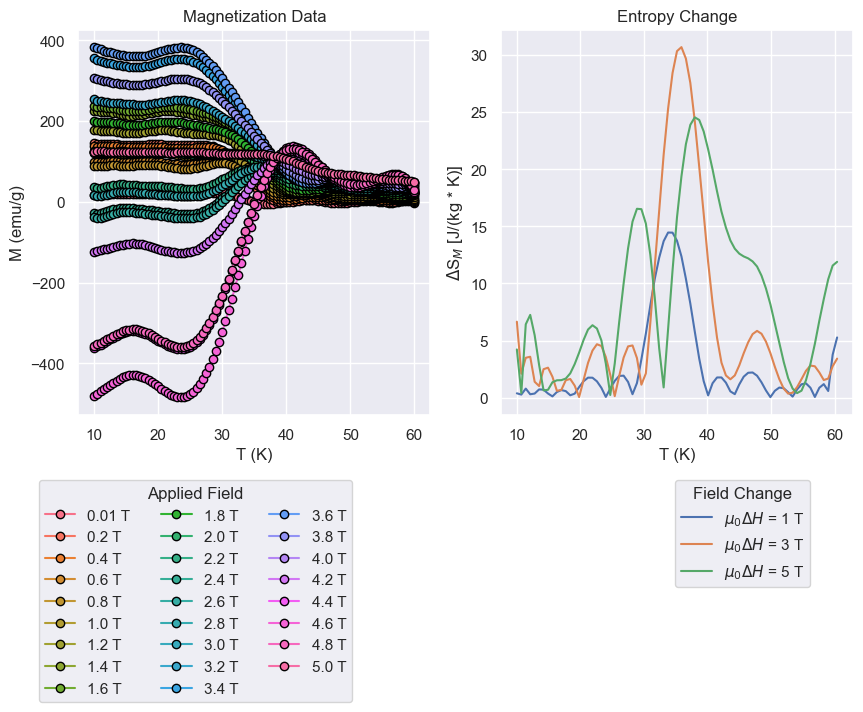

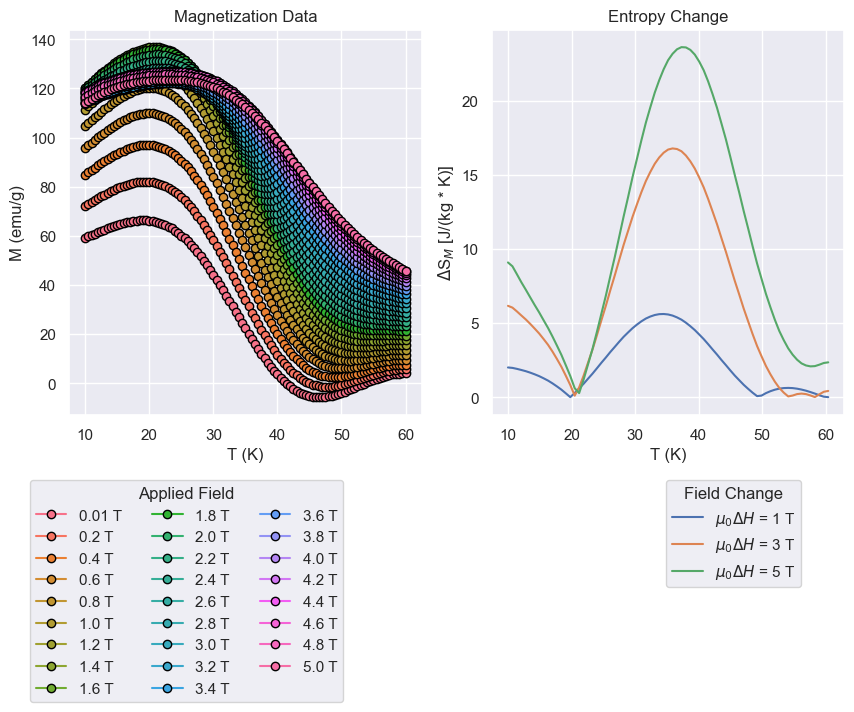

In [232]:
for model_type, model in models:
    print(f"Training {model_type}....")
    model.fit(X_train, y_train)
    gen_data = generate_data_mce(model = model, start = 0.2, end = 5.0, step = 0.2)
    entropy = plot_entropy_curve(data=gen_data, 
                       temperature_column="t", 
                       field_column="h", 
                       magnetization_column="m", 
                       unstandarize=False,  
                       bbox_mag = (0.8, -0.15), 
                       n_cols=3, bbox_ds = (0.9, -0.15),
                       return_entropy = True)
    results[model_type] = (entropy, gen_data, model)
    print("Finished!")

# Now check with old results

In [247]:
import seaborn as sns
ds_dataframes = [
    (entropy_exp, 'Exp. (Coarse)'),
    (entropy_fine, 'Exp. (Fine)'),
#     (sim_entropy, 'Simulated (Streamlit)'),
    (jupyter_sim, 'Simulated (Jupyter)'),
#     (new_model_entropy, 'Simulated (New Model)'),
    (results['linear'][0], 'Linear'),
    (results['random forest'][0], 'Random Forest'),
    (results['nn-scikit'][0], 'Neural Net. (sklearn)'),
    (results['gaussian_process'][0], 'Guassian Process'),
    (results['kernel'][0], 'Kernel Regression')
]
colors = ["grey", "red"] + list(sns.color_palette(palette = "dark", n_colors=len(ds_dataframes) - 2))
paramaters = ['--', 'o-', 'v-'] + ['-.']*(len(ds_dataframes) - 3)



(20.0, 50.0)

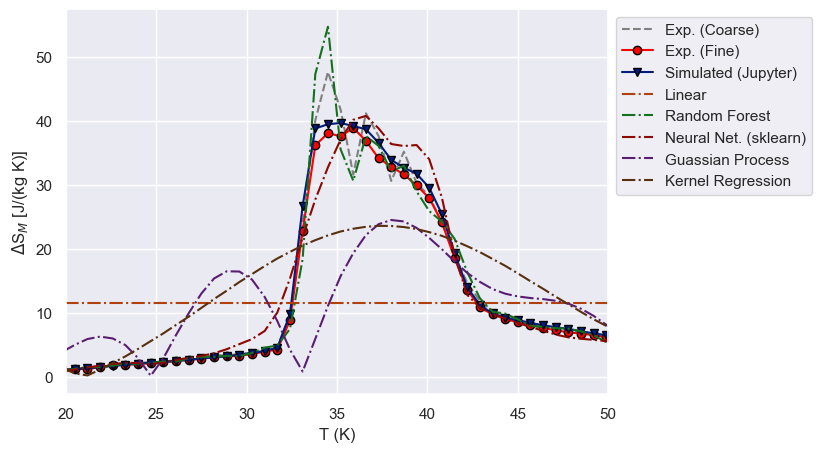

In [248]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for (ds_df, label), color, param in zip(ds_dataframes, colors, paramaters):
    df_plot = ds_df.query("dh == @field")
    plt.plot(df_plot.t, df_plot.ds,param, mec='black', label = label, color=color)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")
plt.xlim([20,50])